In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import pickle

import torch
from anndata import AnnData, read_h5ad
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

/home/jonaheaton/miniconda3/envs/rtd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jonaheaton/miniconda3/envs/rtd/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/jonaheaton/miniconda3/envs/rtd/lib/python3.9/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the follo

In [12]:
start_time = time.time()


In [14]:
time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))

'00:00:11'

In [2]:
# sys.path.append("../")
sys.path.insert(0, "../")
#You may need to add scGPT to the python path
# export PYTHONPATH="${PYTHONPATH}:/app/mz_embed_engine/scgpt"

import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt import prepare_data, prepare_dataloader, define_wandb_metrcis, evaluate, eval_testdata, train, test

from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

from misc import download_data_file
from sklearn.metrics import confusion_matrix



/home/jonaheaton/mz_embed_engine/ml/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jonaheaton/mz_embed_engine/ml/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jonaheaton/miniconda3/envs/rtd/lib/python3.9/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [3]:
home_dir = os.path.expanduser("~")
data_dir = os.path.join(home_dir, "DATA2")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [4]:
hyperparameter_defaults = dict(
    task="annotation",
    seed=42,
    dataset_name="metab_v0",
    do_train=True,
    # load_model = f"{data_dir}/save/dev_metabolomics_apr24-Apr27-03-37",
    # load_model="save/scGPT_bc",
    # load_model = None,
    mask_value=-1,
    pad_value=-2,
    include_zero_gene=True,
    pad_token="<pad>",
    mask_ratio=0.25, # ratio of masked values, default was 0.4
    epochs=5, #original was 30
    # n_bins=101, #counts/intensity bins, default was 51
    n_bins=51, #counts/intensity bins, default was 51
    GEP=True,  # (MLM) Gene expression prediction, Gene expression modelling
    GEPC=True,  #(MVC) Masked value prediction for cell embedding, Gene expression modelling for cell objective
    CLS=True,  # celltype classification objective
    CCE =False,  # Contrastive cell embedding objective
    ESC=False,  # (ECS) Elastic similarity constraint, require ecs_thres>0
    ecs_thres=0,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable. default was 0.8 in the paper it was 0.6
    DAR=False,  # (DAB) Domain adversarial loss
    DSBN = False, # Domain-spec batchnorm
    ADV = False,  # Adversarial training for batch correction
    input_style = "binned",  # "normed_raw", "log1p", or "binned"
    output_style = "binned",  # "normed_raw", "log1p", or "binned"
    input_emb_style = "continuous",  # "category" or "continuous" or "scaling"
    input_layer_key = "X_binned",
    dab_weight=0.0, # weight for domain adversarial loss
    cell_emb_style = "cls",  # "avg-pool" or "w-pool" or "cls"
    adv_E_delay_epochs=0,  # delay adversarial training on encoder for a few epochs
    adv_D_delay_epochs=0,  # delay epochs for domain adversarial loss
    lr=1e-4,
    batch_size=32, #default was 64
    # layer_size=128,
    # nlayers=4,
    # nhead=4,
    layer_size=64,
    nlayers=2,
    nhead=2,

    lr_ADV = 1e-3,  # learning rate for discriminator, used when ADV is True
    # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    schedule_interval=1, # interval of epochs for learning rate schedule
    save_eval_interval=2, #original was 5
    log_interval=100,
    fast_transformer=False, #need CUDA for this
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    n_hvg=False, # number of highly variable genes
    # n_hvg = 1200,  # Default number of highly variable genes
    n_hvp = 4000, # number of highly variable proteins
    # max_seq_len = 4001, # # Default n_hvg+1
    max_seq_len=1201, #1200 was the amount specified in the paper
    freeze = False, #freeze
    per_seq_batch_sample = True, # whether to sort samples by batch_id
    explicit_zero_prob = True, # whether explicit bernoulli for zeros
    normalize_total = False, # 3. whether to normalize the raw data and to what sum
    use_batch_labels = False, # whether to use batch labels, default was True
    use_mod = False, #modality aware? set to True for multi-omics
    do_sample_in_train = False, # sample the bernoulli in training, 
    # celltype_label="Cohort Label",
    # datasubset_label = 'pretrain_set',
    # trainsubset_label = 'Train',
    # valsubset_label = 'Val',
    # testsubset_label = 'Test',
    # celltype_label="MSKCC_binary_id",
    # datasubset_label = 'finetune_set',
    # trainsubset_label = 'Finetune',
    # valsubset_label = 'Validation',
    # celltype_label="sex",
    # datasubset_label = 'pretrain_set'
   
    load_model = f"{data_dir}/save/dev_metab_v0-May16-14-47",
    celltype_label="IMDC",
    datasubset_label = 'finetune_set',
    trainsubset_label = 'Finetune',
    valsubset_label = 'Validation',

    testsubset_label = 'Test',
)       

In [5]:
warnings.filterwarnings('ignore', category=UserWarning, message='^User provided device_type of \'cuda\', but CUDA is not available')

# create a class that takes a dictionary and creates class variables for each of the key and values in the input dictionary
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

    def show(self):
        for attr, value in self.__dict__.items():
            print(f"{attr}: {value}")
              



# %%
USE_WANDB = True


In [6]:
save_dir = '/home/jonaheaton/DATA2/save/dev_metab_v0-May16-12-32'

In [7]:
config = Config(hyperparameter_defaults)

In [8]:
dataset_name = 'metab_v0'    
load_dir = Path(f"{data_dir}/{dataset_name}")
load_dir.mkdir(parents=True, exist_ok=True)
load_path = load_dir / "data.h5ad"
# if not os.path.exists(load_path):
    # print('downloading data')
    # download_data_file(data_url, save_dir=load_dir)
adata = read_h5ad(load_path)
# adata = scvi.data.pbmc_dataset()  # 11990 × 3346
ori_batch_col = "Study ID"
celltype_label= config.celltype_label
adata.obs["celltype"] = adata.obs[celltype_label].astype("category")
adata.obs["Age Group"] = ['adult' if 'adult' in x else 'child' for x in adata.obs["Cohort Label"]]

datasubset_label = config.datasubset_label
trainsubset_label = config.trainsubset_label
valsubset_label = config.valsubset_label
testsubset_label = config.testsubset_label



In [15]:
adata.obs

,Cohort Label,Study ID,batch_id,celltype,celltype_id,Age,OS,OS_Event,PFS,PFS_Event,...,IMDC,MSKCC_ordinal_id,MSKCC_binary_id,IMDC_ordinal_id,IMDC_binary_id,finetune_set,pretrain_set,sex,sex_id,Age Group
0582_Marios_PD1_Inhib2_HP-EA003798-7.mzML,adult_cancer,ST001237,4,FAVORABLE,0,62.0,50.562628,0.0,18.299795,1.0,...,FAVORABLE,2.0,1.0,2.0,1.0,Test,NaN,F,1.0,adult
0293_Marios_PD1_Inhib2_HP-E9101785-7.mzML,adult_cancer,ST001237,4,INTERMEDIATE,0,59.0,24.607803,1.0,1.905544,1.0,...,INTERMEDIATE,1.0,NaN,1.0,NaN,Test,NaN,M,0.0,adult
0219_Marios_PD1_Inhib2_HP-EA003799-7.mzML,adult_cancer,ST001237,4,INTERMEDIATE,0,66.0,52.073922,0.0,29.470226,1.0,...,INTERMEDIATE,1.0,NaN,1.0,NaN,Test,NaN,M,0.0,adult
0962_Marios_PD1_Inhib2_HP-E9784758-7.mzML,adult_cancer,ST001237,4,POOR,0,80.0,24.246407,1.0,3.712526,1.0,...,POOR,0.0,0.0,0.0,0.0,Test,NaN,F,1.0,adult
0218_Marios_PD1_Inhib2_HP-E9123067-7.mzML,adult_cancer,ST001237,4,NOT REPORTED,0,60.0,3.614000,1.0,2.759754,1.0,...,NOT REPORTED,0.0,0.0,NaN,NaN,Test,NaN,M,0.0,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188_Marios_PD1_Inhib2_HP-AE052720-7.mzML,adult_cancer,ST001237,4,INTERMEDIATE,0,56.0,60.254620,0.0,5.683778,1.0,...,INTERMEDIATE,2.0,1.0,1.0,NaN,Finetune,NaN,M,0.0,adult
1023_Marios_PD1_Inhib2_HP-AD185798-7.mzML,adult_cancer,ST001237,4,FAVORABLE,0,72.0,28.977413,1.0,5.552361,0.0,...,FAVORABLE,2.0,1.0,2.0,1.0,Finetune,NaN,M,0.0,adult
1093_Marios_PD1_Inhib2_HP-AE726342-7.mzML,adult_cancer,ST001237,4,FAVORABLE,0,58.0,25.856300,1.0,9.232033,1.0,...,FAVORABLE,2.0,1.0,2.0,1.0,Finetune,NaN,F,1.0,adult
0925_Marios_PD1_Inhib2_HP-AE673799-7.mzML,adult_cancer,ST001237,4,FAVORABLE,0,52.0,19.679700,1.0,5.552361,1.0,...,FAVORABLE,2.0,1.0,2.0,1.0,Finetune,NaN,M,0.0,adult


In [11]:
adata[adata.obs['Study ID'] == 'ST000422'].obs['Cohort Label'] = 'adult_other'

10jan12_26-r001.mzML    adult_cancer
10jan12_56-r001.mzML    adult_cancer
10jan12_13-r002.mzML    adult_cancer
10jan12_81-r002.mzML    adult_cancer
10jan12_55-r002.mzML    adult_cancer
10jan12_24-r001.mzML    adult_cancer
10jan12_62-r001.mzML    adult_cancer
10jan12_28-r002.mzML    adult_cancer
10jan12_43-r002.mzML    adult_cancer
10jan12_26-r002.mzML    adult_cancer
10jan12_15-r001.mzML    adult_cancer
10jan12_15-r002.mzML    adult_cancer
10jan12_56-r002.mzML    adult_cancer
10jan12_39-r001.mzML    adult_cancer
10jan12_13-r001.mzML    adult_cancer
10jan12_40-r002.mzML    adult_cancer
10jan12_23-r002.mzML    adult_cancer
10jan12_14-r001.mzML    adult_cancer
10jan12_44-r001.mzML    adult_cancer
10jan12_60-r001.mzML    adult_cancer
10jan12_25-r002.mzML    adult_cancer
10jan12_59-r002.mzML    adult_cancer
10jan12_55-r001.mzML    adult_cancer
10jan12_27-r001.mzML    adult_cancer
10jan12_25-r001.mzML    adult_cancer
10jan12_41-r001.mzML    adult_cancer
10jan12_38-r001.mzML    adult_cancer
1

In [17]:
adata = adata[~adata.obs["celltype"].isna()]
adata = adata[adata.obs["celltype"] != "nan"]

In [26]:
adata.obs['IMDC']
# select the subest of data with only FAV and INT cell types
adata = adata[adata.obs["celltype"].isin(["FAV", "INT"])]

0582_Marios_PD1_Inhib2_HP-EA003798-7.mzML       FAVORABLE
0293_Marios_PD1_Inhib2_HP-E9101785-7.mzML    INTERMEDIATE
0219_Marios_PD1_Inhib2_HP-EA003799-7.mzML    INTERMEDIATE
0962_Marios_PD1_Inhib2_HP-E9784758-7.mzML            POOR
0218_Marios_PD1_Inhib2_HP-E9123067-7.mzML    NOT REPORTED
                                                 ...     
1188_Marios_PD1_Inhib2_HP-AE052720-7.mzML    INTERMEDIATE
1023_Marios_PD1_Inhib2_HP-AD185798-7.mzML       FAVORABLE
1093_Marios_PD1_Inhib2_HP-AE726342-7.mzML       FAVORABLE
0925_Marios_PD1_Inhib2_HP-AE673799-7.mzML       FAVORABLE
0917_Marios_PD1_Inhib2_HP-AD424471-8.mzML    INTERMEDIATE
Name: IMDC, Length: 17685, dtype: category
Categories (4, object): ['FAVORABLE', 'INTERMEDIATE', 'NOT REPORTED', 'POOR']

In [18]:

adata.obs["celltype"]

0582_Marios_PD1_Inhib2_HP-EA003798-7.mzML    1.0
0962_Marios_PD1_Inhib2_HP-E9784758-7.mzML    0.0
1036_Marios_PD1_Inhib2_HP-EA251051-7.mzML    0.0
0973_Marios_PD1_Inhib2_HP-E9099273-7.mzML    0.0
0594_Marios_PD1_Inhib2_HP-E9073335-7.mzML    0.0
                                            ... 
0929_Marios_PD1_Inhib2_HP-AE902415-7.mzML    1.0
0767_Marios_PD1_Inhib2_HP-AF003924-9.mzML    1.0
1023_Marios_PD1_Inhib2_HP-AD185798-7.mzML    1.0
1093_Marios_PD1_Inhib2_HP-AE726342-7.mzML    1.0
0925_Marios_PD1_Inhib2_HP-AE673799-7.mzML    1.0
Name: celltype, Length: 451, dtype: category
Categories (2, float64): [0.0, 1.0]

In [15]:
celltypes_labels = adata.obs["celltype_id"].tolist()  # make sure count from 0
celltypes_labels = np.array(celltypes_labels)
celltypes = adata.obs["celltype"].unique().tolist()

In [16]:
celltypes

[1.0, nan, 0.0]

In [12]:
['adult' if 'adult' in x else 'child' for x in adata.obs[celltype_label]]

['adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',
 'adult',


In [ ]:
# torch.save(best_model.state_dict(), save_dir / "best_model.pt")


In [19]:

vocab_file =  f"{save_dir}/vocab.json"
model_config_file = f"{save_dir}/args.json"

genes = adata.var["gene_name"].tolist()
pad_token="<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
vocab = GeneVocab.from_file(vocab_file)
vocab.set_default_index(vocab["<pad>"])
embsize = config.layer_size 
nhead = config.nhead
nlayers = config.nlayers  
d_hid = config.layer_size
ntokens = len(vocab)  # size of vocabulary

celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata.obs["celltype"].unique()
num_types = len(np.unique(celltype_id_labels))


adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
num_batch_types = len(set(batch_id_labels))

In [20]:

model = TransformerModel(
    ntoken=ntokens,
    d_model=embsize,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    # nlayers_cls: int = 3,
    n_cls=num_types,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    do_mvc=config.GEPC,
    do_dab=config.DAR,
    use_batch_labels=config.use_batch_labels,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    # input_emb_style: str = "continuous",
    n_input_bins=config.n_bins,
    # cell_emb_style: str = "cls",
    # mvc_decoder_style: str = "inner product",
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=config.explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
    # use_mod=config.use_mod,
    # ntokens_mod=ntokens_mod if config.use_mod else None,
    # vocab_mod=vocab_mod if config.use_mod else None,
)
gene_ids = np.array(vocab(genes), dtype=int)

In [21]:
model_file =f"{save_dir}/best_model.pt"
model.load_state_dict(torch.load(model_file))

# best_model = torch.load(f"{save_dir}/best_model.pt")

<All keys matched successfully>

In [22]:
data_is_raw = True
filter_gene_by_counts = False
adata_protein = None

preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=config.normalize_total,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=config.n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch" if dataset_name != "heart_cell" else None)


scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


In [23]:
adata_test = adata[adata.obs[datasubset_label] == testsubset_label].copy()
if 'X_umap' not in adata_test.obsm.keys():
    sc.pp.neighbors(adata_test)
    sc.tl.umap(adata_test)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [24]:
logger = scg.logger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))
predictions, labels, results = test(model=model,
                                    adata=adata_test,
                                    gene_ids=gene_ids,
                                    vocab=vocab,
                                    config=config,
                                    device=device,
                                    logger=logger)
# adata_test_raw.obs["predictions"] = [id2type[p] for p in predictions]
adata_test.obs["predictions"] = [id2type[p] for p in predictions]

scGPT - INFO - Accuracy: 0.212, Precision: 0.058, Recall: 0.250, Macro F1: 0.094, Micro F1: 0.212


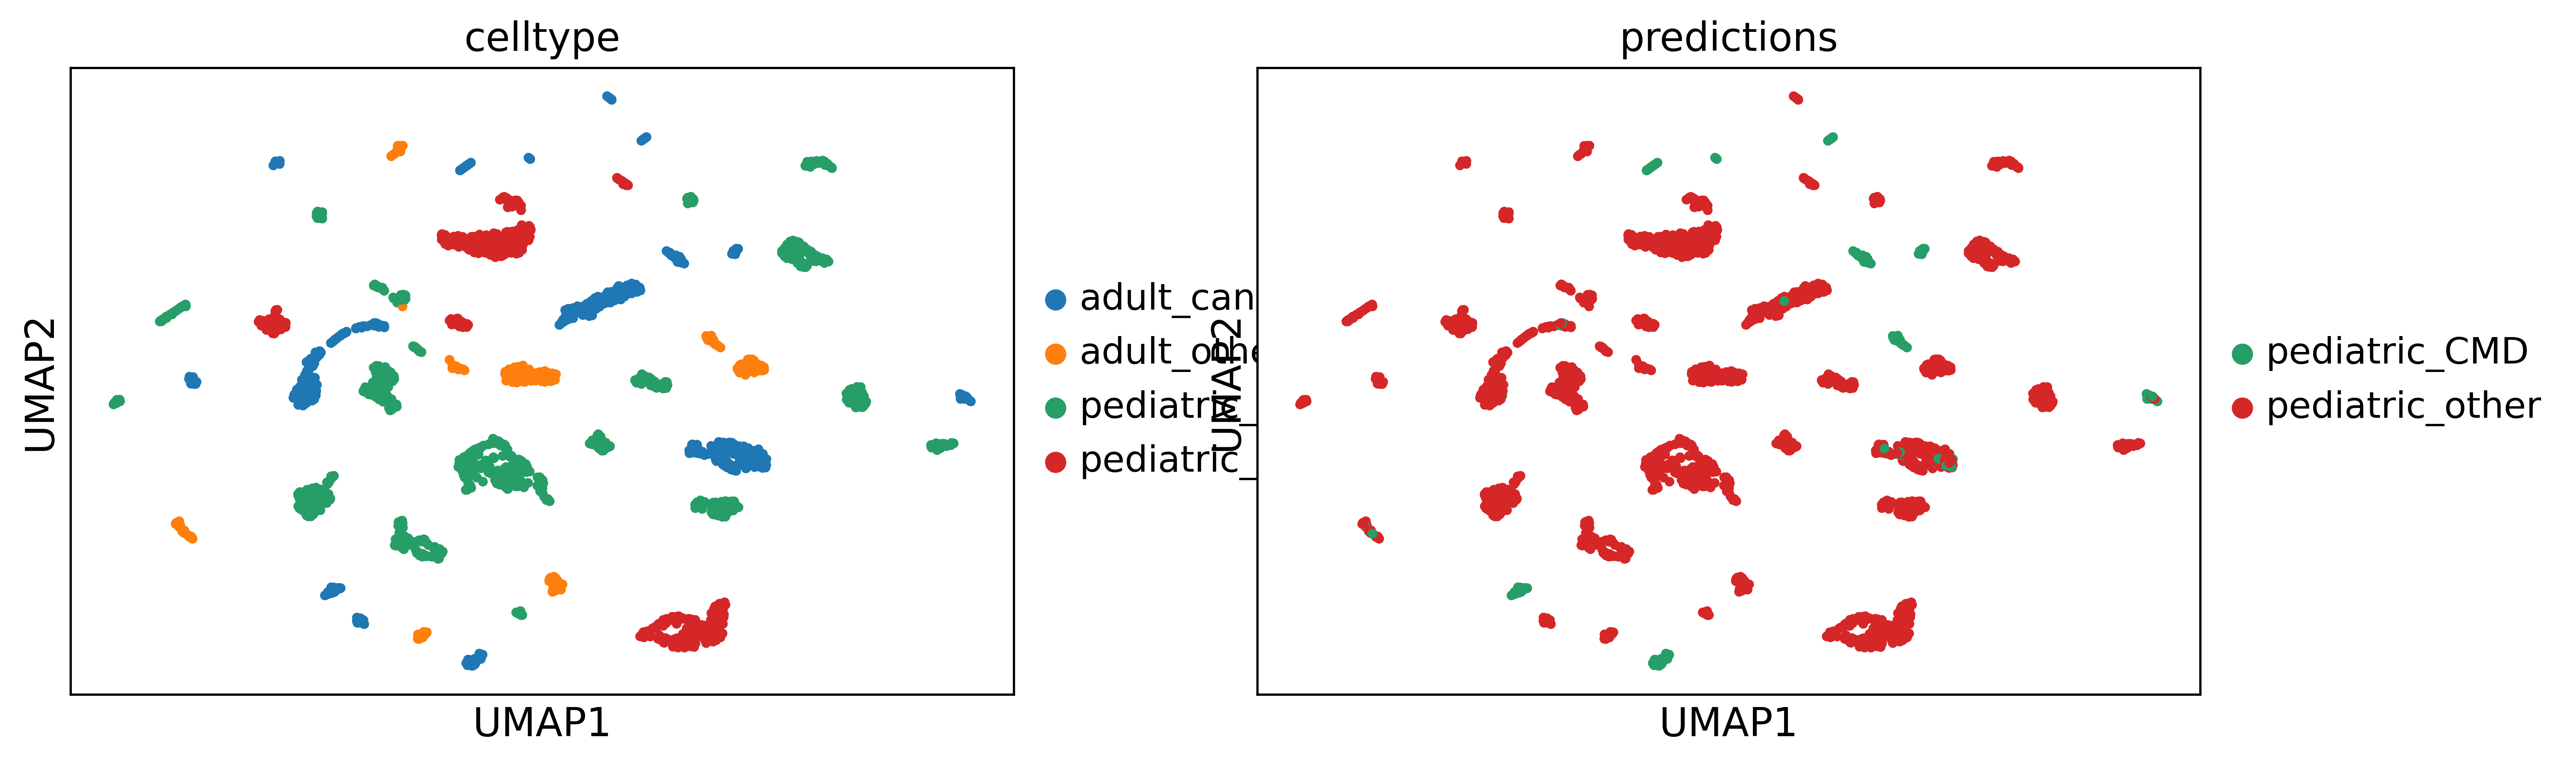

In [26]:
# plot
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] 
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette_ = {c: palette_[i] for i, c in enumerate(celltypes)}

save_dirpath = Path(f"{save_dir}")
with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi": (300)}):
    sc.pl.umap(
        adata_test,
        # adata_test_raw,
        color=["celltype", "predictions"],
        palette=palette_,
        show=False,
    )
    plt.savefig(save_dirpath / "results.png", dpi=300)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

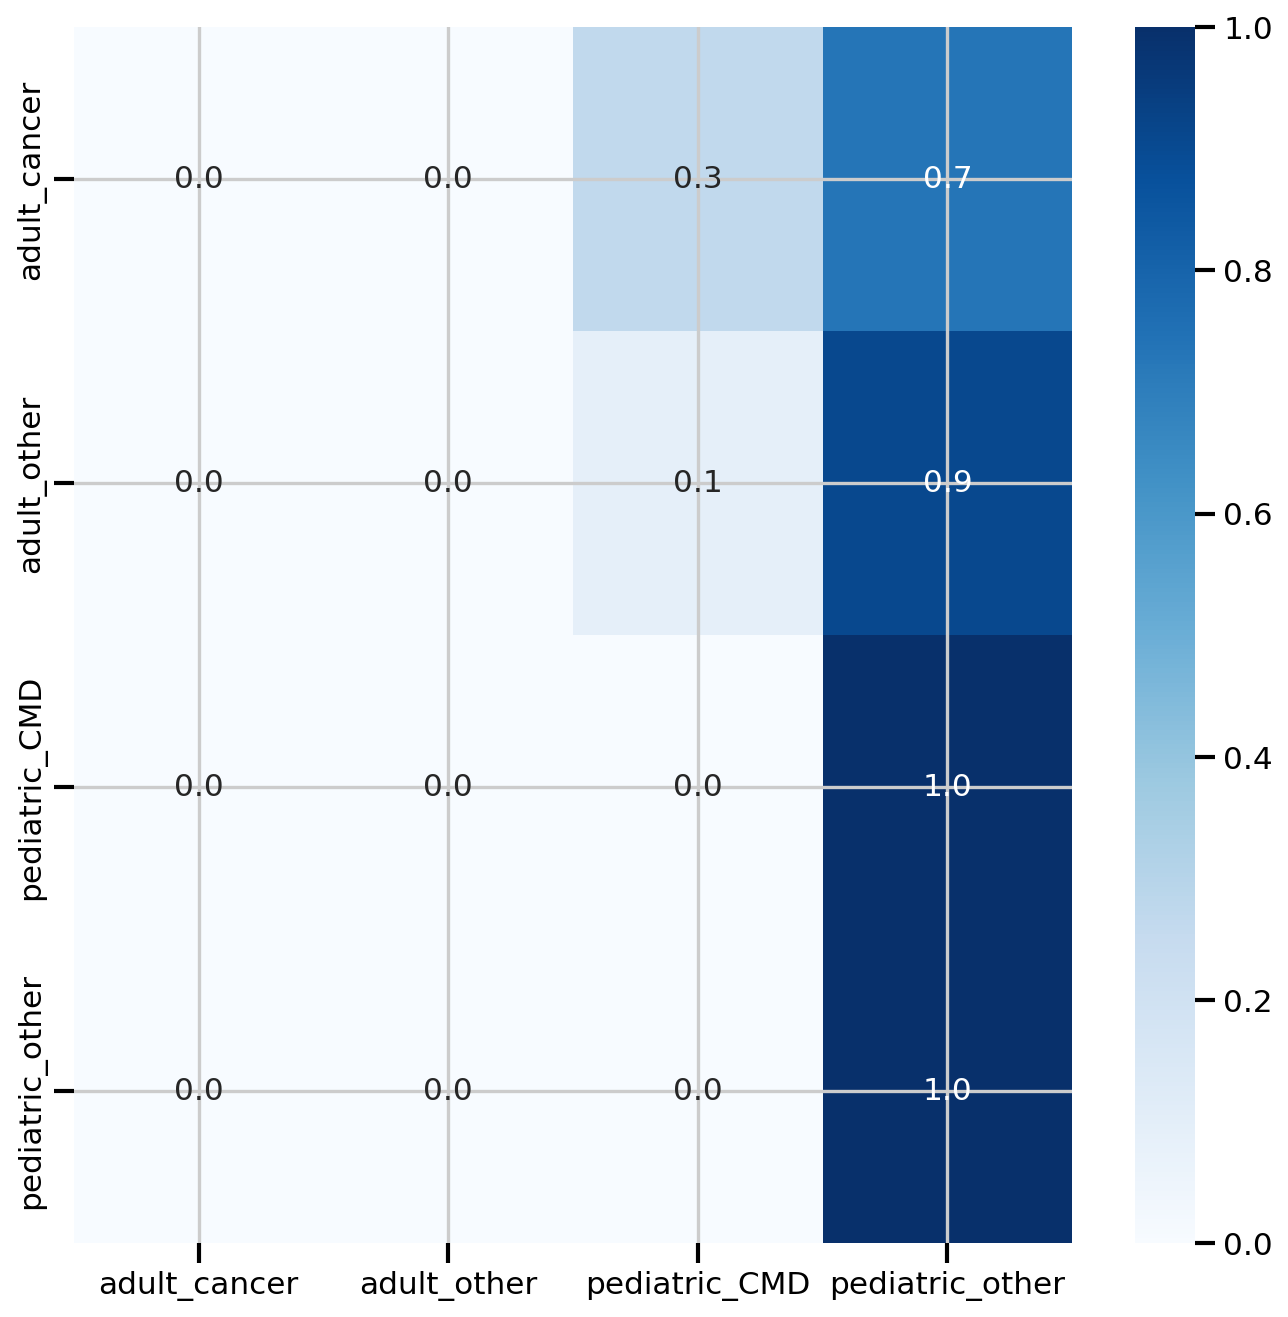

In [27]:
celltypes = list(celltypes)
for i in set([id2type[p] for p in predictions]):
    if i not in celltypes:
        celltypes.remove(i)
cm = confusion_matrix(labels, predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=celltypes[:cm.shape[0]], columns=celltypes[:cm.shape[1]])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
plt.savefig(save_dir / "confusion_matrix.png", dpi=300)